In [1]:
import numpy as  np

In [3]:
data  = np.load('/Users/tuhinkhare/Work/GaTech-MSCS/Fall-24/CS-8803-SMR/SysMLTeam12/plotting-per-layer-2-tk/0/saved_models/bert_base-SST-2-two_stage/accLat_75_100.0.npy', allow_pickle=True)

array([{1: 872, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0},
       {1: 0.006621836795719391, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0},
       0.08333333333333333, {1: 0.7373853211009175}], dtype=object)

In [22]:
entropies = [0.0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

data_pl = {} # e -> [exit_layer_count, eval_time, actual_cost/full_cost, accuracy]
for e in entropies:
    data_pl[e] = np.load('./../plotting2/saved_models/bert_base-SST-2-two_stage/entropy_{}.npy'.format(e), allow_pickle=True)

In [11]:
import numpy as np
num_layers = 12
latencies_per_layer = [] # latencies is in seconds
for layer in range(0, num_layers):
    data = np.load(f'/Users/tuhinkhare/Work/GaTech-MSCS/Fall-24/CS-8803-SMR/SysMLTeam12/plotting-per-layer-2-tk/{layer}/saved_models/bert_base-SST-2-two_stage/accLat_75_100.0.npy', allow_pickle=True)
    data_list = data.tolist()
    # print(data_list)
    latency = data_list[1][layer+1]
    latencies_per_layer.append(latency)
print(latencies_per_layer)

[0.006228963442898671, 0.011305577711227838, 0.01925427213721319, 0.02513984447225518, 0.0284253771698803, 0.028320326170790087, 0.041825170637270724, 0.04413026461907483, 0.044111000835348704, 0.05392835255062908, 0.055279964153919746, 0.056254678636515905]


[0.73738532 0.77981651 0.78555046 0.78899083 0.79701835 0.84059633
 0.86009174 0.87844037 0.9059633  0.91513761 0.91399083 0.91743119]


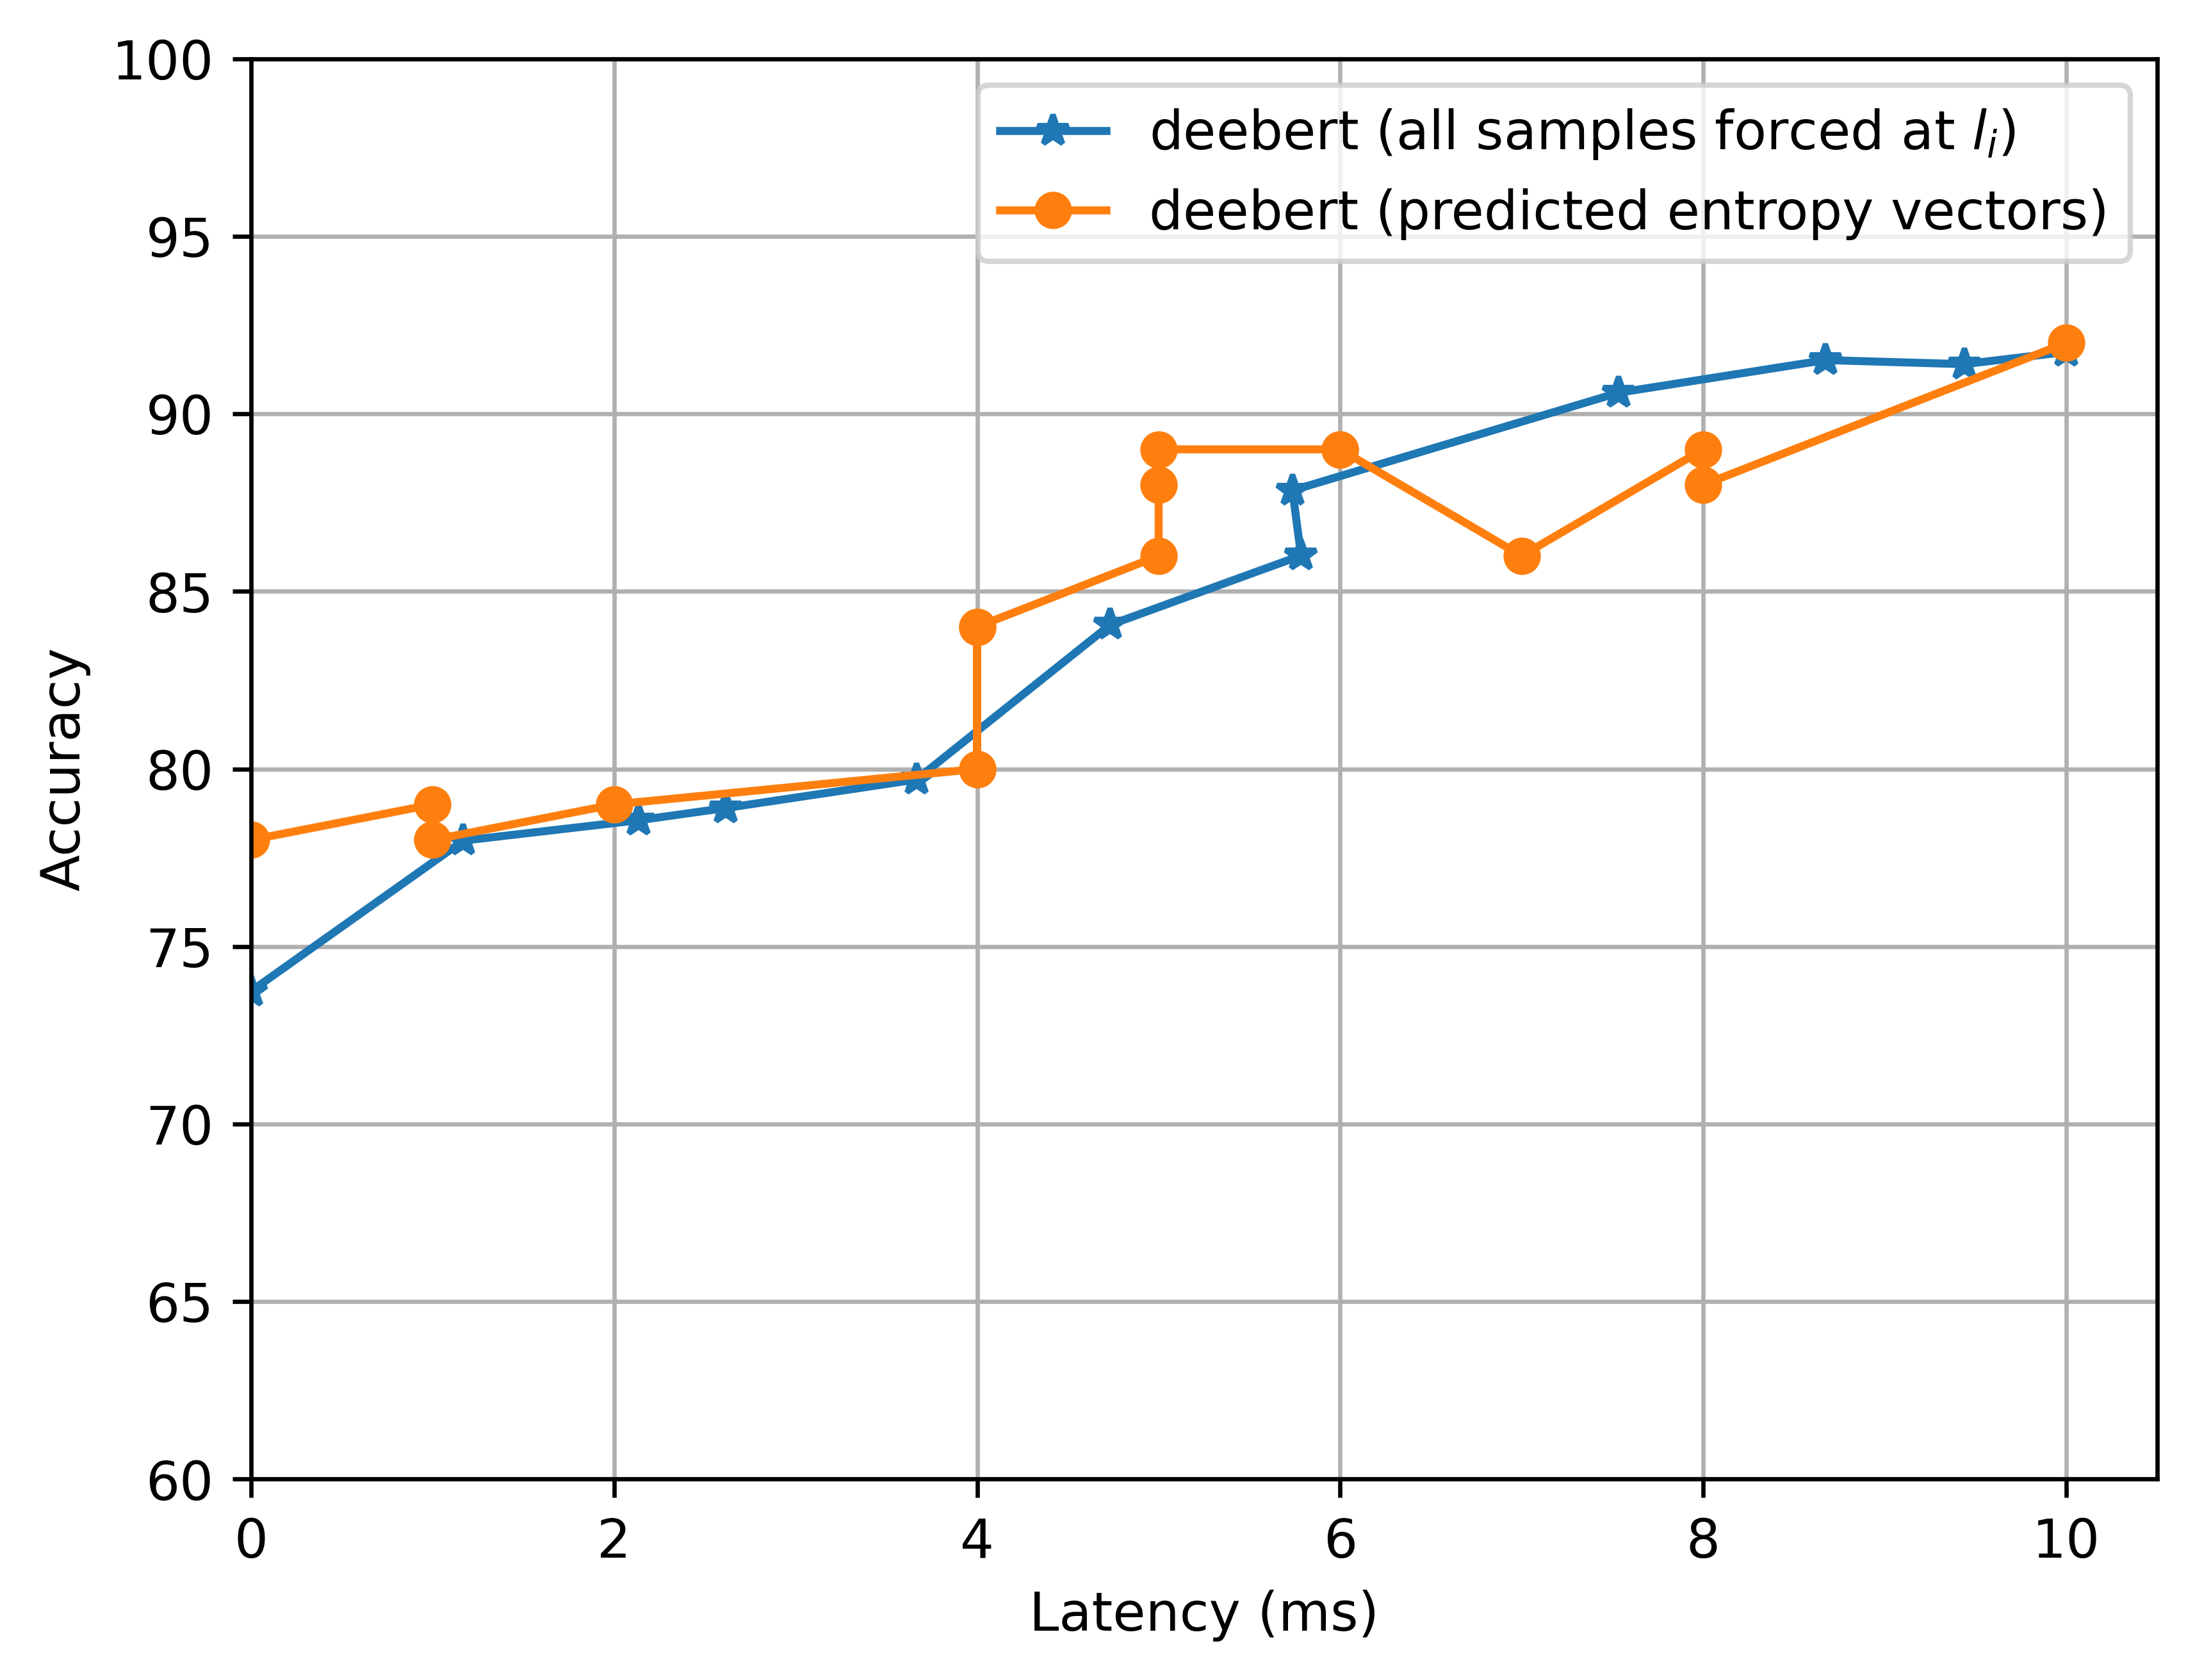

In [46]:
import matplotlib.pyplot as plt


def normalise(x):
    x_min = np.min(x)
    x_max = np.max(x)
    normalised_x = ((x - x_min)/(x_max - x_min))*10
    return normalised_x

num_layers=12
pl_latency = []
pl_acc = []

ground_truth = np.load("/Users/tuhinkhare/Work/GaTech-MSCS/Fall-24/CS-8803-SMR/SysMLTeam12/plotting/saved_models/bert_base-SST-2-two_stage/each_layer.npy")
print(ground_truth)

post_entropy_acc = [78, 79, 78, 79, 80, 84, 80, 84, 86, 88, 89, 89, 89, 86, 89, 88, 92]
post_entropy_latency = [3, 4, 4, 5, 7, 7, 7, 7, 8, 8, 8, 9, 9, 10, 11, 11, 13]

# post_entropy_acc = list((78, 78, 79, 79, 80, 80, 84, 84, 86, 88, 90, 91, 91))
# post_entropy_latency = list((3, 4, 4, 5, 6, 7, 7, 7, 8, 8, 9, 10, 10))

for layer in range(num_layers):
    path = f"/Users/tuhinkhare/Work/GaTech-MSCS/Fall-24/CS-8803-SMR/SysMLTeam12/plotting-per-layer/{layer}/saved_models/bert_base-SST-2-two_stage/accLat_75_100.npy"
    data = list(np.load(path, allow_pickle=True))
    latency = data[1][layer+1]*100
    accuracy = data[3][layer+1]*100
    pl_latency.append(latency)
    pl_acc.append(accuracy)

fig, ax = plt.subplots()

# for i, label in enumerate([str(x+1) for x in range(num_layers)]):
#     ax.annotate(label, (pl_latency[i], pl_acc[i]))


# ax.plot(normalise(pl_latency), pl_acc, marker='o')
ax.plot(normalise(pl_latency), [x*100 for x in ground_truth], marker='*', label='deebert (all samples forced at $l_{i}$)')
ax.plot(normalise(post_entropy_latency),post_entropy_acc, marker='o', label='deebert (predicted entropy vectors)')
ax.set_xlabel("Latency (ms)")
ax.set_ylabel("Accuracy")
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=60, ymax=100)
ax.legend()
ax.grid(True)
fig.set_dpi(600)
# ax.set_title("AL space offered by Forcing all samples to exit at $layer_{i}$\n vs \n\
#               AL space offered by using per layer entropy vectors as a control parameter")

# note = num_sampels passed from layer, latency for h elayers, accuracy for the layer

In [4]:
path = "/Users/tuhinkhare/Work/GaTech-MSCS/Fall-24/CS-8803-SMR/SysMLTeam12/plotting/saved_models/bert_base-SST-2-two_stage/each_layer.npy";
data = np.load(path, allow_pickle=True);
print(data)

[0.73738532 0.77981651 0.78555046 0.78899083 0.79701835 0.84059633
 0.86009174 0.87844037 0.9059633  0.91513761 0.91399083 0.91743119]


In [47]:
acc_buckets = {}
# for acc in range(60, 100, 5):
#     acc_buckets[acc] = []

for e in entropies:
    for exit_layer in data_pl[e][3]:
        acc = int(data_pl[e][3][exit_layer] * 20) * 5
        if acc >= 60:
            if acc not in acc_buckets:
                acc_buckets[acc] = []
            latency = int(data_pl[e][1][exit_layer] * 1000)
            exit_layer_count = data_pl[e][0][exit_layer]
            acc_buckets[int(acc/5)*5].append((latency, exit_layer, e, exit_layer_count))

for acc in acc_buckets:
    print(acc, sorted(acc_buckets[acc]))


90 [(21, 1, 0.5, 107), (32, 2, 0.3, 299), (35, 2, 0.2, 200), (48, 3, 0.05, 54), (92, 6, 0.15, 102), (96, 6, 0.2, 96), (99, 6, 0.05, 89), (102, 7, 0.001, 13), (111, 7, 0.15, 114), (111, 7, 0.3, 89), (120, 8, 0.15, 104), (123, 8, 0.1, 138), (128, 8, 0.2, 82), (177, 12, 0.0, 872)]
100 [(30, 2, 0.01, 8), (32, 2, 0.001, 2), (35, 2, 0.005, 2), (37, 2, 0.05, 54), (47, 3, 0.005, 9), (47, 3, 0.01, 15), (62, 4, 0.005, 23), (65, 4, 0.05, 60), (72, 4, 0.001, 3), (74, 5, 0.005, 9), (78, 5, 0.1, 33), (79, 5, 0.01, 12), (80, 5, 0.001, 7), (80, 5, 0.05, 23), (99, 6, 0.001, 32), (105, 7, 0.005, 46), (119, 8, 0.6, 5), (128, 9, 0.6, 2), (154, 11, 0.15, 2), (156, 11, 0.3, 2), (158, 11, 0.4, 1), (159, 11, 0.001, 15), (175, 11, 0.1, 8), (219, 12, 0.5, 1)]
85 [(16, 1, 0.6, 271), (32, 2, 0.4, 385), (34, 2, 0.5, 421), (47, 3, 0.3, 111), (50, 3, 0.4, 98), (61, 4, 0.15, 90), (64, 4, 0.1, 69), (67, 4, 0.2, 91), (79, 5, 0.3, 50), (87, 5, 0.2, 44), (91, 6, 0.5, 51), (95, 6, 0.4, 58), (95, 6, 0.6, 22), (102, 6, 0.3,

In [61]:
# Accuracy is prioritized. We acheive the highest accuracy possible within the latency budget.
def get_entropies(targt_accuracy, target_latency):
    entropies = [(0, 0, 10)] * 12 # e, acc, latency
    for acc in acc_buckets:
        if acc < targt_accuracy:
            continue
        for latency, exit_layer, e, _ in acc_buckets[acc]:
            if latency > target_latency:
                continue
            if entropies[exit_layer][1] < acc or (entropies[exit_layer][1] == acc and entropies[exit_layer][2] > latency):
                entropies[exit_layer] = (e, acc, latency)
   
    res = []
    for e, _, _ in entropies:
        res.append(e)
    
    for i in range(len(res) - 1, 0, -1):
        if res[i] != 0:
            res[i] = 1
            break
    return res

print("for 90% acc, 100ms latency: ", get_entropies(90, 100))
print("for 90% acc, 150ms latency: ", get_entropies(90, 150))
print("for 80% acc, 150ms latency: ", get_entropies(80, 150))
print("for 80% acc, 120ms latency: ", get_entropies(80, 120))
print("for 70% acc, 120ms latency: ", get_entropies(70, 120))
print("for 70% acc, 100ms latency: ", get_entropies(70, 100))
            
            

for 90% acc, 100ms latency:  [0, 0.4, 0.01, 0.005, 0.005, 0.005, 1, 0, 0, 0, 0, 0]
for 90% acc, 150ms latency:  [0, 0.4, 0.01, 0.005, 0.005, 0.005, 0.001, 0.005, 0.6, 0.6, 1, 0]
for 80% acc, 150ms latency:  [0, 0.4, 0.01, 0.005, 0.005, 0.005, 0.001, 0.005, 0.6, 0.6, 1, 0]
for 80% acc, 120ms latency:  [0, 0.4, 0.01, 0.005, 0.005, 0.005, 0.001, 0.005, 1, 0, 0, 0]
for 70% acc, 120ms latency:  [0, 0.4, 0.01, 0.005, 0.005, 0.005, 0.001, 0.005, 1, 0, 0, 0]
for 70% acc, 100ms latency:  [0, 0.4, 0.01, 0.005, 0.005, 0.005, 1, 0, 0, 0, 0, 0]


In [79]:
print("for 75% acc, 100ms latency: ", get_entropies(75, 100))

for 75% acc, 100ms latency:  [0, 0.4, 0.01, 0.005, 0.005, 0.005, 1, 0, 0, 0, 0, 0]


In [5]:
import matplotlib.pyplot as plt

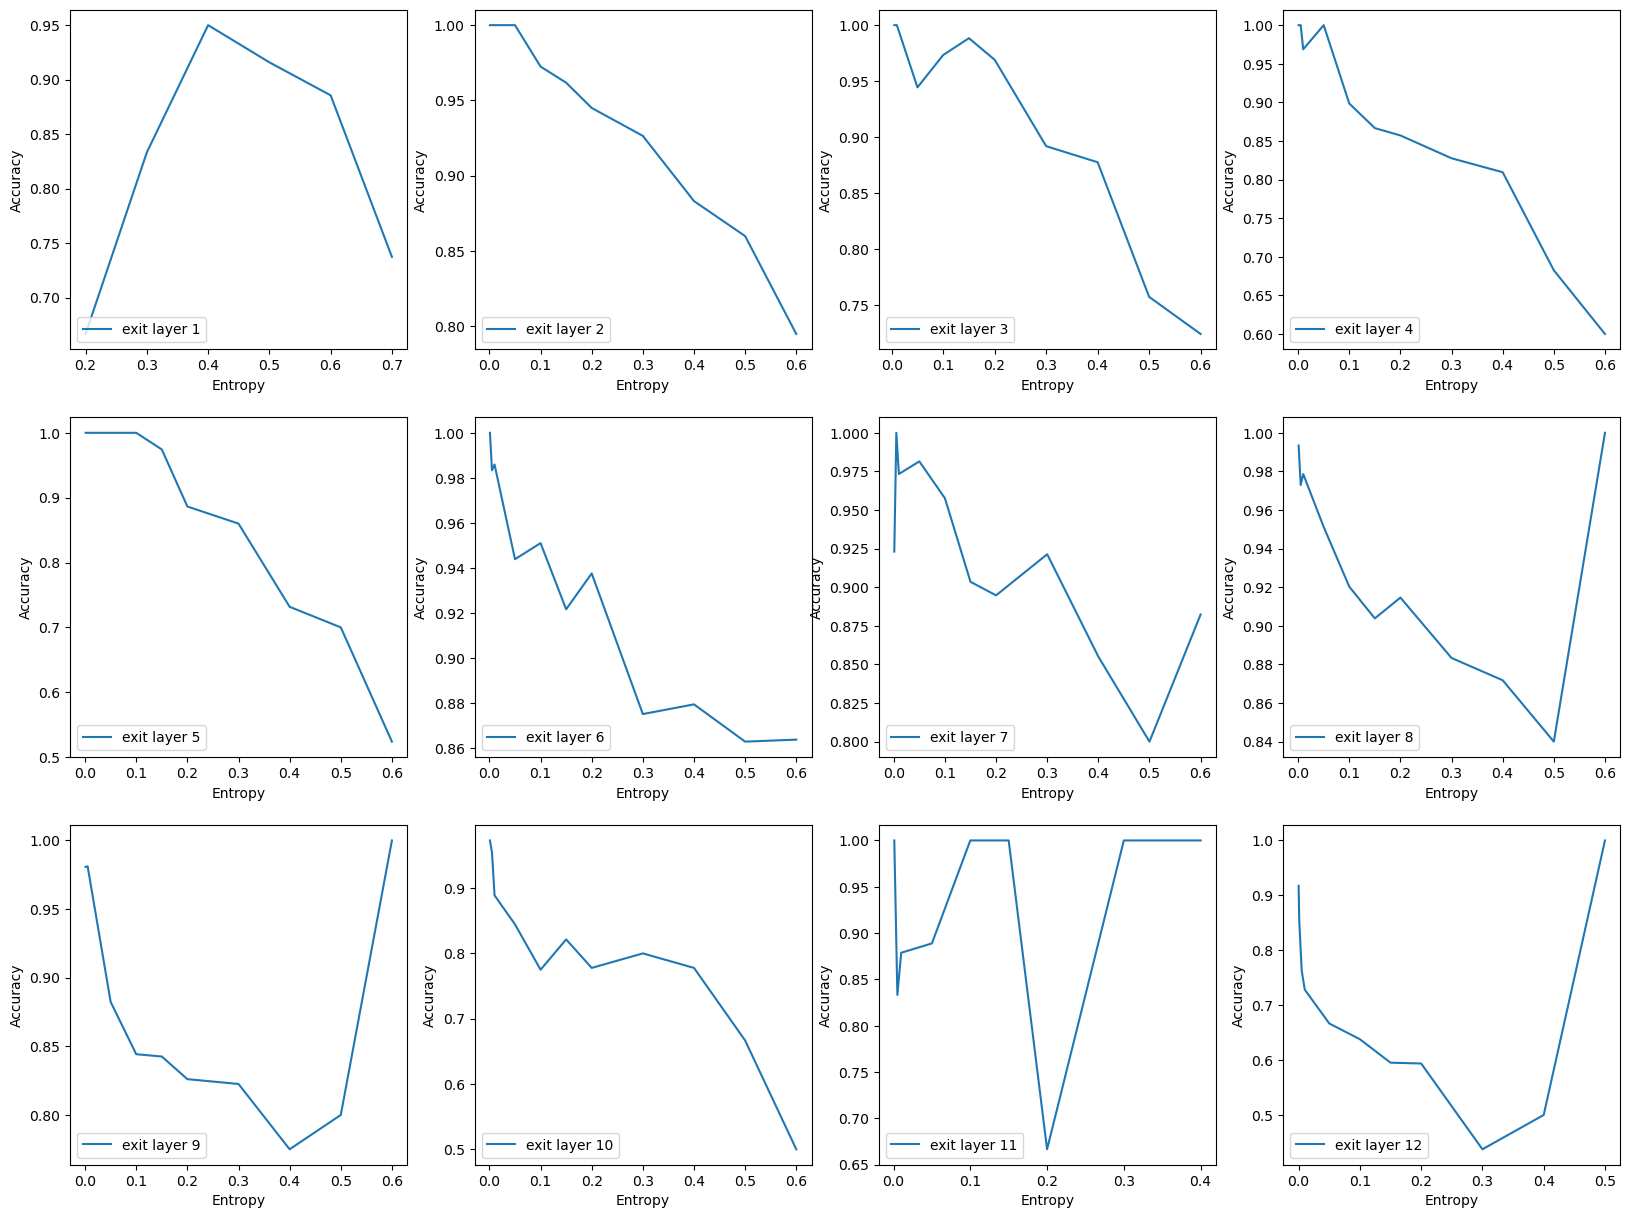

In [40]:
def plot_accuracy_entropy(data_pl, entropies):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
    for exit_layer in data_pl[0][0]:
        xvals=[]
        yvals=[]
        for e in entropies:
            if exit_layer in data_pl[e][3]:
                xvals.append(e)
                yvals.append(data_pl[e][3][exit_layer])
        ax = plt.subplot(3, 4, exit_layer)
        ax.set_xlabel('Entropy')
        ax.set_ylabel('Accuracy')
        ax.plot(xvals, yvals, label='exit layer {}'.format(exit_layer))
        ax.legend(loc='lower left')
    plt.show()
plot_accuracy_entropy(data_pl, entropies)

In [66]:
data_accLat_90_150 = np.load('./../plotting2/saved_models/bert_base-SST-2-two_stage/accLat_{}_{}.npy'.format(90, 150), allow_pickle=True)
print(data_accLat_90_150)

[{1: 0, 2: 424, 3: 0, 4: 0, 5: 0, 6: 6, 7: 3, 8: 106, 9: 310, 10: 17, 11: 6, 12: 0}
 {1: 0, 2: 0.030887295614998294, 3: 0, 4: 0, 5: 0, 6: 0.08540070056915283, 7: 0.09722900390625, 8: 0.11355175612107762, 9: 0.12480902594904746, 10: 0.13616587133968577, 11: 0.15102994441986084, 12: 0}
 0.45670871559633025
 {2: 0.8915094339622641, 8: 0.9811320754716981, 9: 0.864516129032258, 10: 0.6470588235294118, 11: 0.8333333333333334, 7: 1.0, 6: 1.0}]


In [ ]:
data_accLat_90_150 = np.load('./../plotting2/saved_models/bert_base-SST-2-two_stage/accLat_{}_{}.npy'.format(90, 150), allow_pickle=True)
print(data_accLat_90_150)

In [77]:
def compute_overall_accuracy_latency(data_accLat):
    total = 0
    acc = 0
    latency = 0
    for exit_layer in data_accLat[0]:
        if exit_layer in data_accLat[3]:
            total += data_accLat[0][exit_layer]
            acc += data_accLat[0][exit_layer] * data_accLat[3][exit_layer]
            latency += data_accLat[0][exit_layer] * data_accLat[1][exit_layer]
    return acc/total, latency/total

acc, latency = compute_overall_accuracy_latency(data_accLat_90_150)
print("Target Accuracy: 90%, Average Latency: 150ms ")
print(f"Achieved Accuracy: {round(acc*100)}%, Average Latency: {round(latency * 1000)}ms")

Target Accuracy: 90%, Average Latency: 150ms 
Achieved Accuracy: 89%, Average Latency: 78ms


In [78]:
data_accLat_80_120 = np.load('./../plotting2/saved_models/bert_base-SST-2-two_stage/accLat_{}_{}.npy'.format(80, 120), allow_pickle=True)
acc, latency = compute_overall_accuracy_latency(data_accLat_80_120)
print("Target Accuracy: 80%, Average Latency: 120ms ")
print(f"Achieved Accuracy: {round(acc*100)}%, Average Latency: {round(latency * 1000)}ms")

Target Accuracy: 80%, Average Latency: 120ms 
Achieved Accuracy: 88%, Average Latency: 90ms


In [81]:
data_accLat_75_100 = np.load('./../plotting2/saved_models/bert_base-SST-2-two_stage/accLat_{}_{}.npy'.format(75, 100), allow_pickle=True)
acc, latency = compute_overall_accuracy_latency(data_accLat_75_100)
print("Target Accuracy: 75%, Average Latency: 100ms ")
print(f"Achieved Accuracy: {round(acc*100)}%, Average Latency: {round(latency * 1000)}ms")

Target Accuracy: 75%, Average Latency: 100ms 
Achieved Accuracy: 85%, Average Latency: 70ms


In [3]:
from collections import defaultdict
import json
import pprint

path = "/Users/tuhinkhare/Work/GaTech-MSCS/Fall-24/CS-8803-SMR/SysMLTeam12/plotting-per-layer-2-tk"
per_layer_out = defaultdict(list)
num_layers = 12 

for layer_idx in range(0, num_layers):
    fp = f"{path}/{layer_idx}/layer_metrics.json"
    with open(fp, "r") as json_file:
        d = json.load(json_file)
    pred = d['preds']
    labels = d['labels']
    for id, entropy in enumerate(d['entropies']):
        value = int(pred[id] == labels[id])
        per_layer_out[layer_idx].append((format(entropy, ".4f"), value))

pprint.pprint(per_layer_out)

defaultdict(<class 'list'>,
            {0: [('0.4994', 1),
                 ('0.3990', 1),
                 ('0.5535', 1),
                 ('0.6134', 1),
                 ('0.6390', 1),
                 ('0.4136', 1),
                 ('0.5095', 0),
                 ('0.5253', 1),
                 ('0.6349', 1),
                 ('0.5176', 1),
                 ('0.5559', 1),
                 ('0.6557', 0),
                 ('0.6732', 1),
                 ('0.6913', 0),
                 ('0.6920', 1),
                 ('0.2024', 1),
                 ('0.6558', 1),
                 ('0.5512', 1),
                 ('0.6557', 1),
                 ('0.6101', 0),
                 ('0.6889', 1),
                 ('0.6844', 1),
                 ('0.6551', 1),
                 ('0.4173', 1),
                 ('0.6364', 1),
                 ('0.6604', 1),
                 ('0.6829', 1),
                 ('0.6202', 1),
                 ('0.6849', 1),
                 ('0.5845', 1),
            

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for demonstration
nrow = 4
ncol = 3
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 10))  # 4 rows, 3 columns
fig.set_dpi(1000)
for i in range(nrow):
    for j in range(ncol):
        index = i * 3 + j  # Calculate the index for the sine waves
        data = sorted(per_layer_out[index], key=lambda x: x[0])
        # print(data)
        num_correct = len([x for x in data if x[1] == 1])
        num_wrong = len([x for x in data if x[1] == 0])
        entropies = [x[0] for x in data]
        count_n = len([x for x in entropies if float(x) < 0.1])
        # print(f"Layer - {index}, count(0 -> 0.25) - {count_n}")
        axs[i, j].scatter([x[0] for x in data], [y[1] for y in data], s=0.25)  # Plot the sine wave

        # axs[i, j].set_xticklabels([str(x[0]) for x in data], rotation=90)
        # axs[i, j].set_xticklabels(rotation=90)
        # axs[i, j].set_xscale('log')
        axs[i, j].set_xticks([])
        axs[i, j].set_title(f'Layer - {index}, #Right - {num_correct}, #Wrong - {num_wrong}')  # Set title for each subplot
        axs[i, j].set_xlabel('Entropies')  # Set x-axis label
        axs[i, j].set_ylabel('Y^ - Y')  # Set y-axis label


plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig("entropies_per_layer_2.pdf")
plt.show()

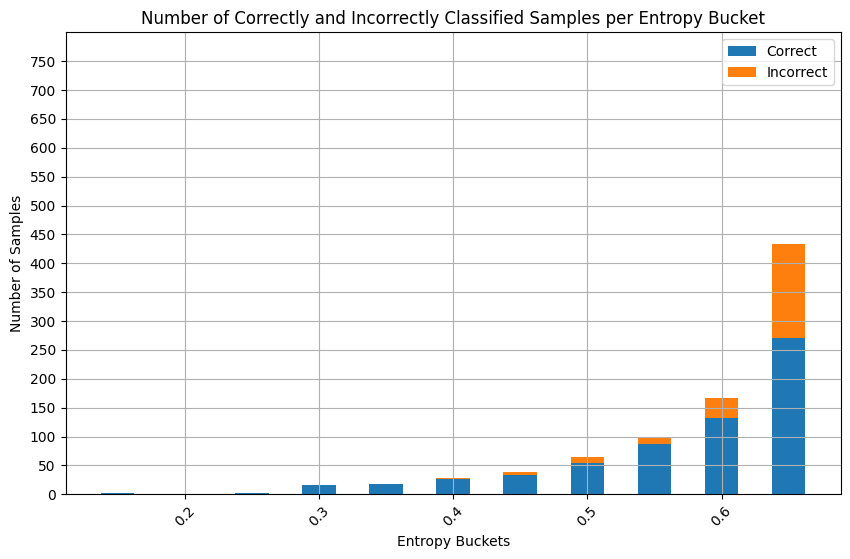

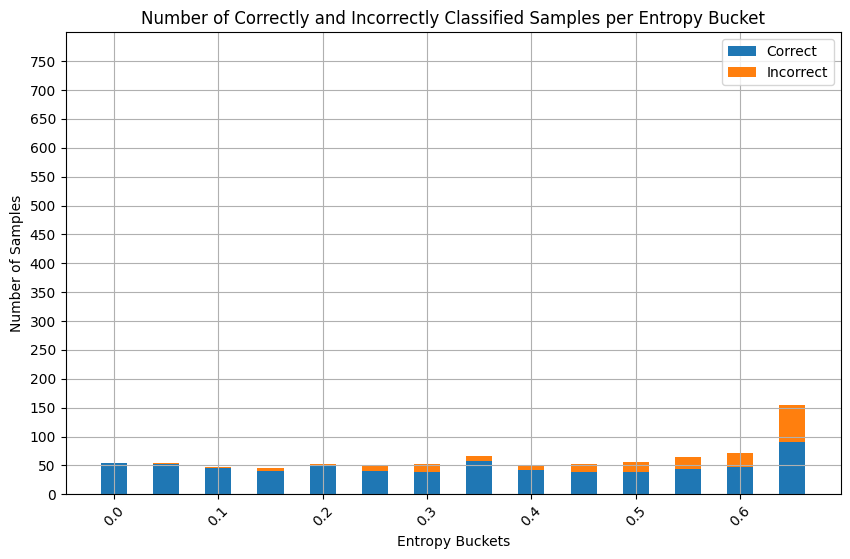

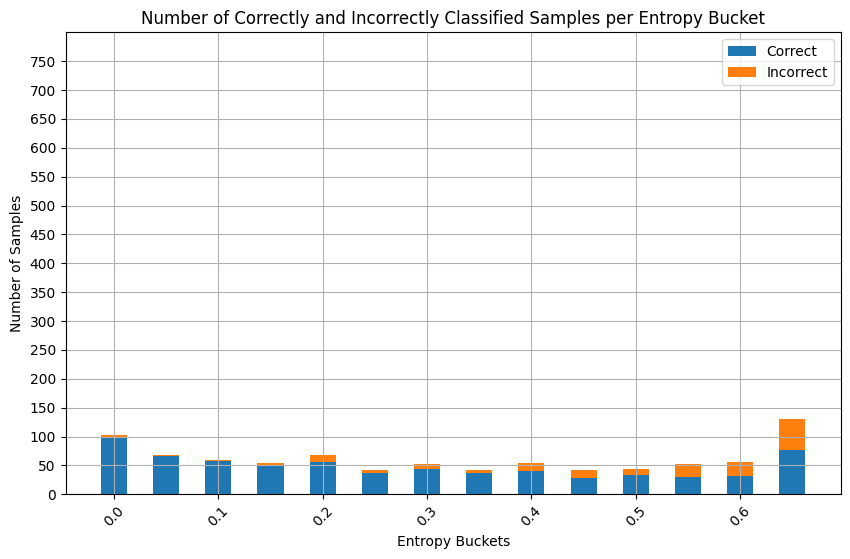

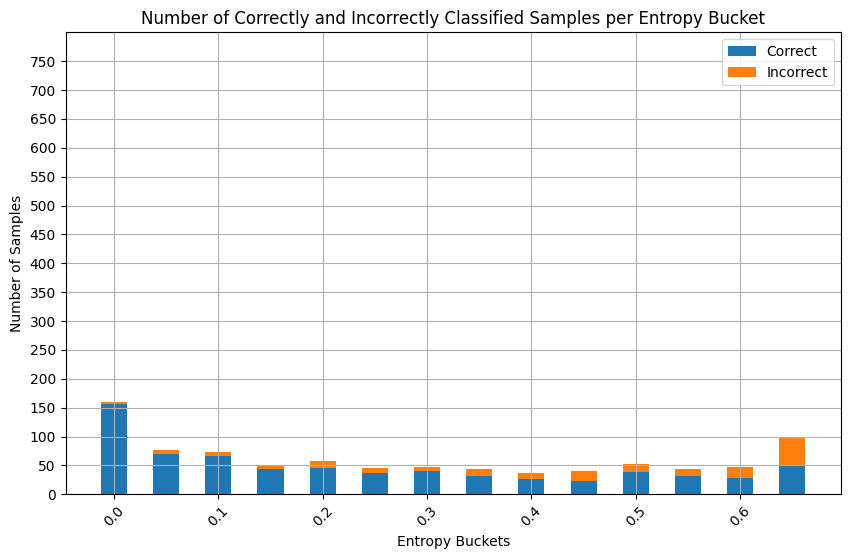

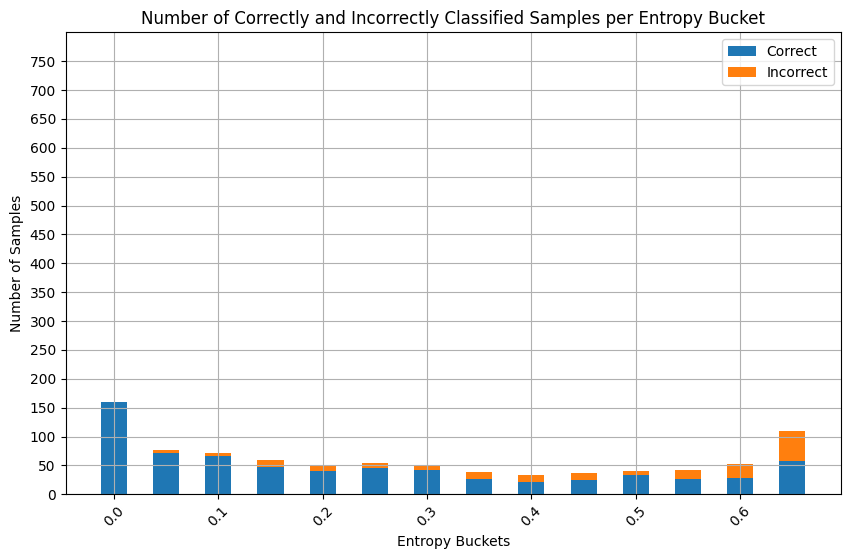

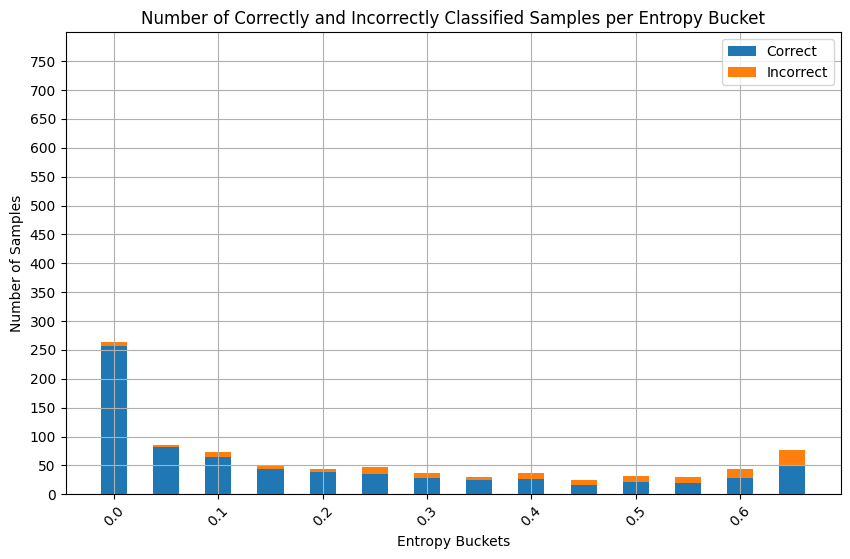

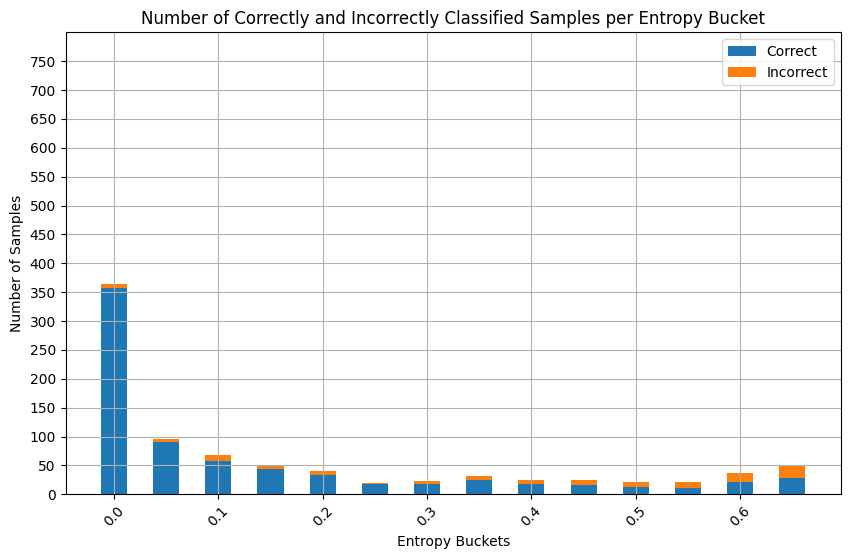

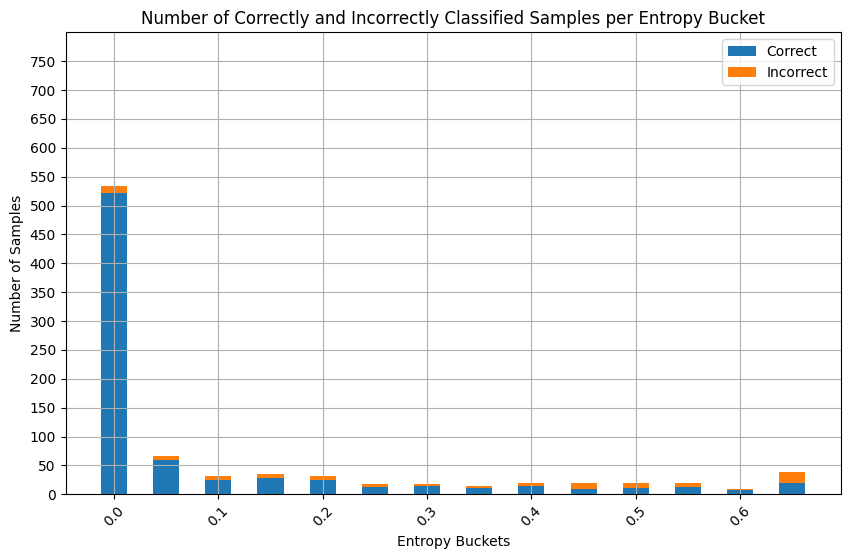

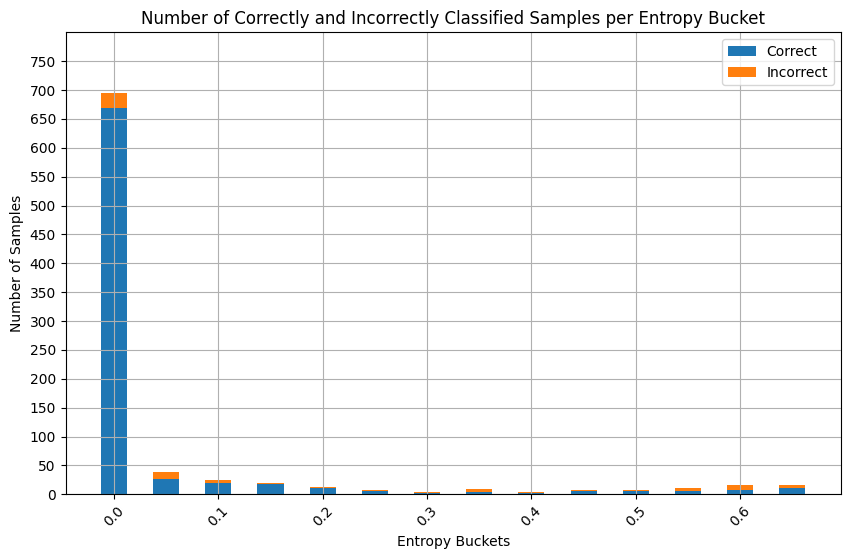

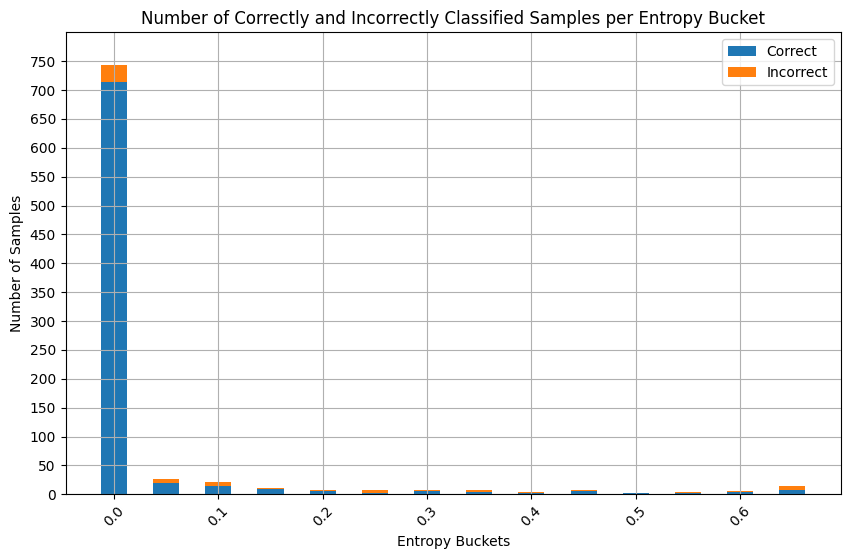

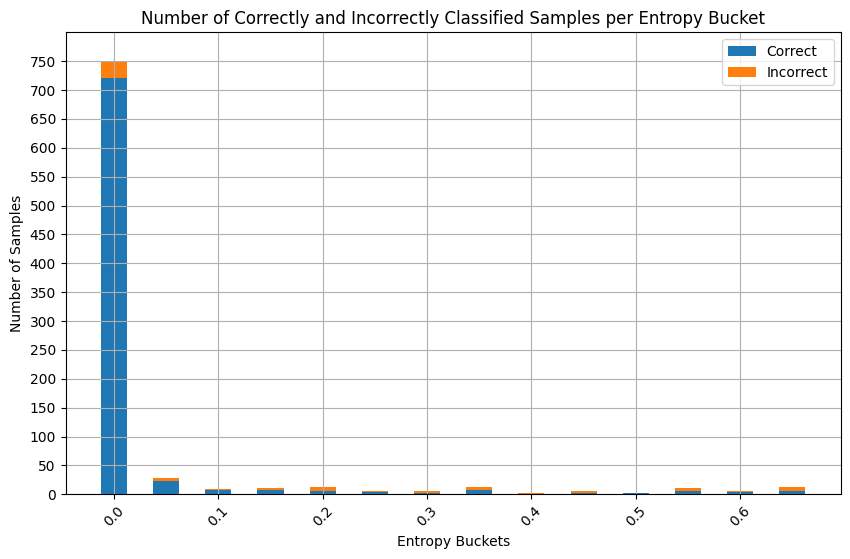

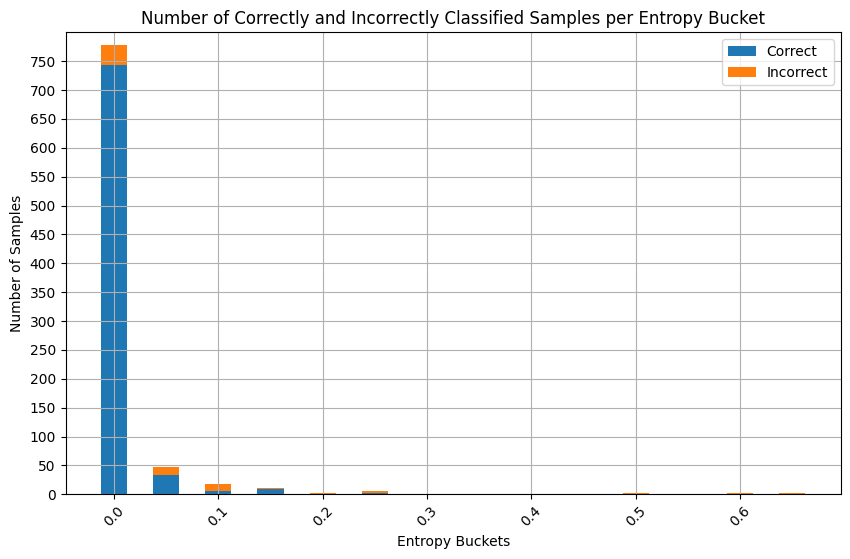

In [29]:
# NOTE - bucket based plot for the number of correctly classified and incorrectly classified samples
# plot a histogram for the same and also see the variation of entropy in that bucket
# Discretize entropy values into buckets of 0.05
bucket_size = 0.05

for layer in per_layer_out:
    buckets = defaultdict(lambda: {'correct': 0, 'incorrect': 0})
    for entropy, correct in per_layer_out[layer]:
        bucket = round(float(entropy) // bucket_size * bucket_size, 2)
        if correct:
            buckets[bucket]['correct'] += 1
        else:
            buckets[bucket]['incorrect'] += 1

# Prepare data for plotting
    bucket_keys = sorted(buckets.keys())
    correct_counts = [buckets[bucket]['correct'] for bucket in bucket_keys]
    incorrect_counts = [buckets[bucket]['incorrect'] for bucket in bucket_keys]

    # Plot the histogram
    fig, ax = plt.subplots(figsize=(10, 6))
    width = bucket_size / 2
    ax.bar(bucket_keys, correct_counts, width=width, label='Correct', align='center')
    ax.bar(bucket_keys, incorrect_counts, width=width, bottom=correct_counts, label='Incorrect', align='center')
    ax.set_ylim(ymin=0, ymax=800)
    yticks = list(range(0, 850, 50))
    ax.set_yticks(yticks)
    ax.set_yticklabels([str(y) for y in yticks])
    ax.set_xlabel('Entropy Buckets')
    ax.set_ylabel('Number of Samples')
    ax.set_title('Number of Correctly and Incorrectly Classified Samples per Entropy Bucket')
    ax.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

In [ ]:
# NOTe
# for profiling - place an upper bound on the exit layer and record the samples that exit prior to that upper bound as well
# adjust to the distributions
# input adaptive , optimizing for SLO attainment and accuracy at the same time.
# we are in the post finetuning stage for the early exit networks
# Trained entropy threshold (someone has )

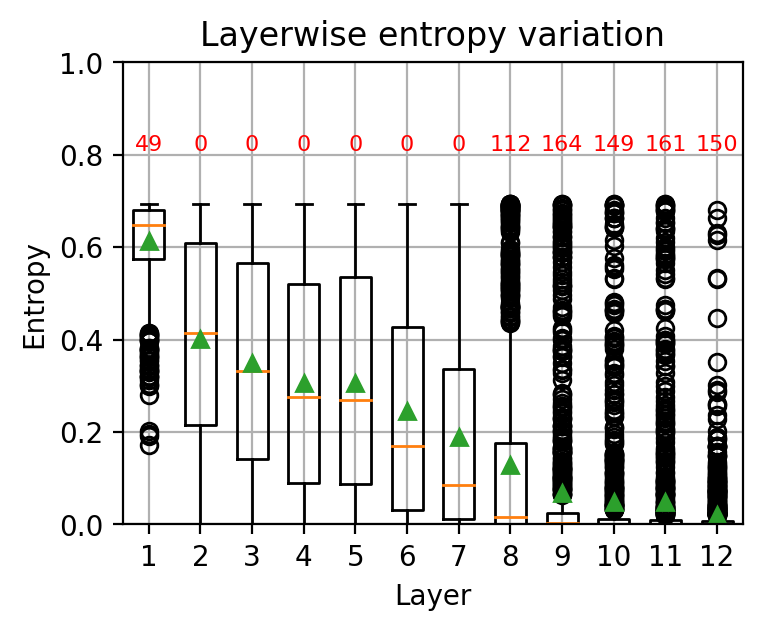

In [28]:
# Box plots for the entropy variation per layer
data = per_layer_out

# construct a list of entropy values per layer
per_layer_entropies = {layer: [float(entropy) for entropy, _ in data[layer]] for layer in data}

# plot the box plots
fig, ax = plt.subplots(figsize=(4, 3))
fig.set_dpi(200)


# Add the number of outliers for each box plot
for layer, entropies in per_layer_entropies.items():
    boxplot = ax.boxplot(entropies, positions=[layer], widths=0.6, showfliers=True, showmeans=True)
    outliers = len(boxplot['fliers'][0].get_ydata())
    ax.text(layer, 0.8, f'{outliers}', ha='center', va='bottom', fontsize=8, fontdict={'color': 'red'})
# iterate over the layers and plot the box plots
_xticks = [layer for layer in per_layer_entropies.keys()]
ax.set_xticks(_xticks)
ax.set_xticklabels([str(x+1) for x in _xticks])
ax.set_ylim(ymin=0, ymax=1.0)
ax.set_xlabel('Layer')
ax.set_ylabel('Entropy')
ax.set_title("Layerwise entropy variation")
ax.grid(True)